In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.size'] = 14
torch.set_default_dtype(torch.float64)

In [3]:
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import QMDataset
from mlelec.utils.twocenter_utils import fix_orbital_order

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
orbitals = {'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
            'gthszvmolopt': {6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]]
                            }}

In [61]:
cs_phase = {}
for basis in orbitals:
    cs_phase[basis] = {}
    for s in orbitals[basis]:
        cs_phase[basis][s] = [np.int32((-1)**v[2]) for v in orbitals[basis][s]]
        # cs_phase[basis][s] = []
        # for v in orbitals[basis][s]:
        #     if v[1] != 1:
        #         cs_phase[basis][s].append(1)
        #     else:
        #         cs_phase[basis][s].append(0)
# np.outer(np.array([1, -1, 1, 0]), np.array([1, -1, -1, -1]))

In [73]:
line = np.concatenate([cs_phase[ORBS][s] for s in frames[0].numbers])
cs = np.outer(line, line)
print(cs)

[[ 1 -1  1 -1  1 -1  1 -1]
 [-1  1 -1  1 -1  1 -1  1]
 [ 1 -1  1 -1  1 -1  1 -1]
 [-1  1 -1  1 -1  1 -1  1]
 [ 1 -1  1 -1  1 -1  1 -1]
 [-1  1 -1  1 -1  1 -1  1]
 [ 1 -1  1 -1  1 -1  1 -1]
 [-1  1 -1  1 -1  1 -1  1]]


In [25]:
cs.shape

(8, 8)

In [91]:
workdir = '/home/pegolo/Software/my_mlelec'
root = f'{workdir}/examples/data/periodic'
# ORBS = 'sto-3g'
ORBS = 'gthszvmolopt'
START = 1
STOP = 2
frames = read(f'{root}/graphene_supercell_variety/graphene_variety.xyz', slice(START, STOP))
# frames = read(f'{root}/c2/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = True

# kmesh = [15,15,1]
# kfock = [1/kmesh[0]*np.load(f"{root}/c2/cp2k/fock_{i}.npy") for i in range(START, STOP)]
# kover = [1/kmesh[0]*np.load(f"{root}/c2/cp2k/overlap_{i}.npy") for i in range(START, STOP)]

kmesh = [9,9,1]
kfock = [1/kmesh[0]*np.load(f"{root}/c2/cp2k/fock_hex.npy") for i in range(START, STOP)]
kover = [1/kmesh[0]*np.load(f"{root}/c2/cp2k/overlap_hex.npy") for i in range(START, STOP)]

# for ifr in range(len(frames)):
#     for ik, k in enumerate(kfock[ifr]):
#         kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
#         kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

line = np.concatenate([cs_phase[ORBS][s] for s in frames[0].numbers])
cs = np.outer(line, line)
# for ifr in range(len(frames)):
#     for ik in range(len(kfock[ifr])):
#         kfock[ifr][ik] = kfock[ifr][ik]*cs
#         kover[ifr][ik] = kover[ifr][ik]*cs

dataset = QMDataset(frames = frames, kmesh = kmesh, fock_kspace = kfock, overlap_kspace = kover, device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)
dataset_o = QMDataset(frames = frames, kmesh = kmesh, fock_kspace = kover, overlap_kspace = kover, device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.



In [40]:
dataset.overlap_realspace[0][2,2,0][:4,:4]

tensor([[7.8310e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])

In [279]:
view(frames[0])

<Popen: returncode: None args: ['/home/pegolo/micromamba/envs/sci/bin/python...>

usage: ase [-h] [--version] [-T]
           {help,info,test,gui,db,run,band-structure,build,dimensionality,eos,ulm,find,nebplot,nomad-upload,nomad-get,convert,reciprocal,completion,diff,exec}
           ...
ase: error: TclError: no display name and no $DISPLAY environment variable
To get a full traceback, use: ase -T gui ...


# Targets

In [92]:
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 

def get_targets(dataset, device ="cpu", cutoff = None):
    blocks = matrix_to_blocks(dataset, dataset._fock_realspace_negative_translations, device = 'cpu', cutoff = cutoff, all_pairs = True)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks

In [129]:
cutoff = None
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff)
target_blocks_o, target_coupled_blocks_o = get_targets(dataset_o, cutoff = cutoff)

# Features

In [135]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH

hypers_pair = {'cutoff': 13,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.6,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
                      kmesh = dataset.kmesh, device="cpu", lcut = LCUT, return_rho0ij = return_rho0ij, counter = dataset._translation_counter, 
                      T_dict = dataset._translation_dict)

if both_centers and not return_rho0ij:
    NU = 3
else:
    NU = 2
rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = 'cpu',
                                feature_names = rhoij.property_names)

hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = all_pairs)

{'cutoff': 13, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}
torch.Size([398, 1, 10]) 1
torch.Size([794, 1, 10]) 2
torch.Size([398, 3, 10]) 1
torch.Size([794, 3, 10]) 2
torch.Size([398, 5, 10]) 1
torch.Size([794, 5, 10]) 2
torch.Size([398, 7, 10]) 1
torch.Size([794, 7, 10]) 2
torch.Size([398, 9, 10]) 1
torch.Size([794, 9, 10]) 2


In [136]:
# rhoij_o = pair_features(dataset_o.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = True,
#                       kmesh = dataset_o.kmesh, device="cpu", lcut = LCUT, return_rho0ij = return_rho0ij, counter = dataset_o._translation_counter, 
#                       T_dict = dataset_o._translation_dict)

# if both_centers and not return_rho0ij:
#     NU = 3
# else:
#     NU = 2
# rhonui_o = single_center_features(dataset_o.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = 'cpu',
#                                 feature_names = rhoij_o.property_names)

# hfeat_o = twocenter_features_periodic_NH(single_center = rhonui_o, pair = rhoij_o, all_pairs = True)

# Train

In [137]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [138]:
def train_ridge(model, target_blocks, set_bias=False):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = False, alphas = np.logspace(-16, 0, 50))

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [139]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True)
print(loss_ridge_bias)

ValueError: operands could not be broadcast together with shapes (322,6) (294,6) 

In [109]:
model_ridge_o = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks_o,
                                  frames = dataset_o.structures, orbitals = dataset_o.basis, 
                                  device = device)

model_ridge_o = model_ridge_o.double()
loss_ridge_bias_o, pred_ridge_bias_o, ridges_bias_o, loss_blocks_o = train_ridge(model_ridge_o, 
                                                                         target_coupled_blocks_o,
                                                                         set_bias = True)
print(loss_ridge_bias_o)

tensor(5.4991)


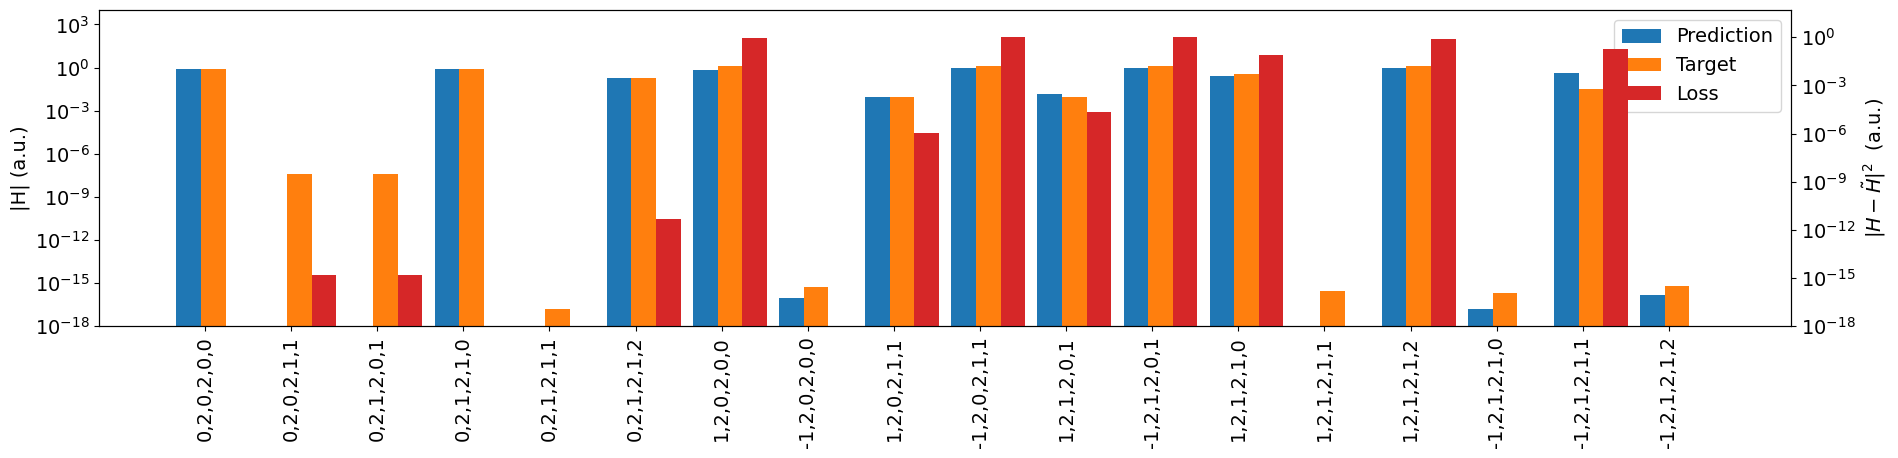

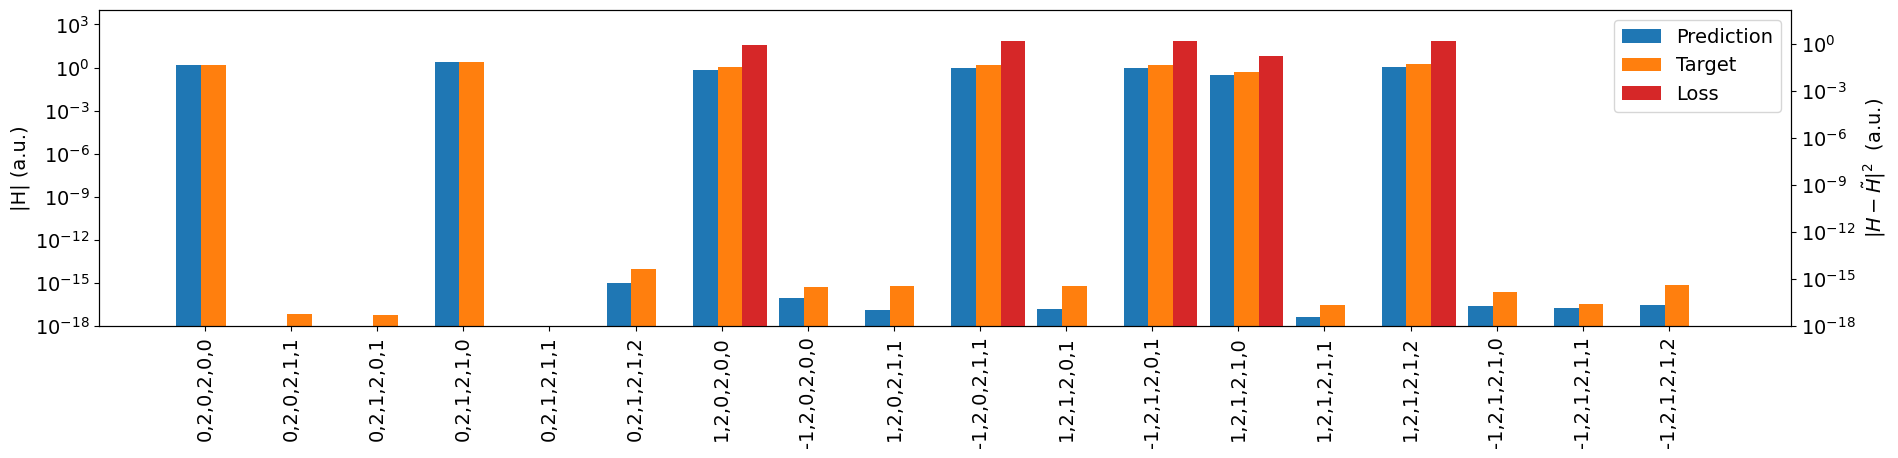

In [110]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss = True)
ax_loss.set_ylim(1e-18,)
ax.set_ylim(1e-18,1e4)
fig.tight_layout()

fig,ax,ax_loss=plot_block_errors(target_coupled_blocks_o, pred_ridge_bias_o, plot_loss = True)
ax_loss.set_ylim(1e-18,)
ax.set_ylim(1e-18,1e4)
fig.tight_layout()

In [89]:
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.twocenter_utils import _to_uncoupled_basis
m = blocks_to_matrix(pred_ridge_bias, dataset)
o = blocks_to_matrix(pred_ridge_bias_o, dataset)


In [90]:
m

[{(0,
   0,
   0): tensor([[-5.9733e-01,  7.2762e-24,  0.0000e+00,  7.4169e-23, -1.0457e-02,
           -4.3521e-20,  0.0000e+00,  2.0268e-02],
          [ 7.2762e-24, -3.7294e-01,  0.0000e+00,  1.6119e-18,  4.3477e-20,
           -7.2638e-03,  0.0000e+00, -7.0447e-15],
          [ 0.0000e+00,  0.0000e+00, -2.0276e-01,  0.0000e+00,  0.0000e+00,
            0.0000e+00, -5.6154e-03,  0.0000e+00],
          [ 7.4169e-23,  1.6119e-18,  0.0000e+00, -3.7294e-01, -2.0268e-02,
           -7.0447e-15,  0.0000e+00,  2.9075e-02],
          [-1.0457e-02,  4.3477e-20,  0.0000e+00, -2.0268e-02, -5.9733e-01,
           -6.5818e-24,  0.0000e+00, -7.4856e-23],
          [-4.3521e-20, -7.2638e-03,  0.0000e+00, -7.0447e-15, -6.5818e-24,
           -3.7294e-01,  0.0000e+00,  1.4828e-18],
          [ 0.0000e+00,  0.0000e+00, -5.6154e-03,  0.0000e+00,  0.0000e+00,
            0.0000e+00, -2.0276e-01,  0.0000e+00],
          [ 2.0268e-02, -7.0447e-15,  0.0000e+00,  2.9075e-02, -7.4856e-23,
            1.4828

In [115]:
# mm = predict(model_ridge, ridges_bias, target_coupled_blocks)

In [51]:
m[0][0,0,0][:4,:4] / dataset.fock_realspace[0][0,0,0][:4,:4]

tensor([[1.0000,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan]])

In [54]:
m[0][0,0,0][4:,:4] / dataset.fock_realspace[0][0,0,0][4:,:4]

tensor([[0.3901,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan]])

In [55]:
m[0][0,0,0][4:,:4] / dataset.fock_realspace[0][0,0,0][4:,:4]

tensor([[0.3901,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan],
        [   nan,    nan,    nan,    nan]])

/tmp/ipykernel_3573520/976260175.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


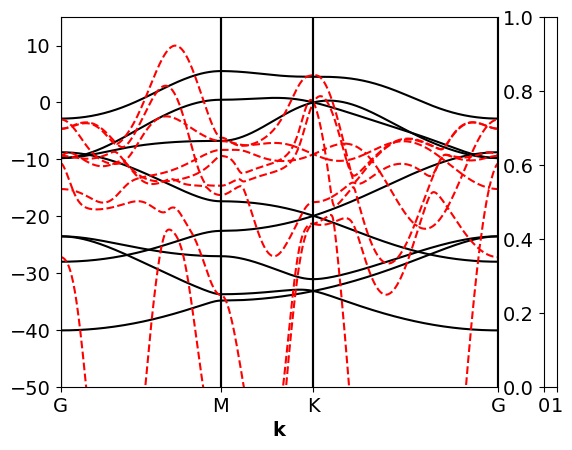

In [260]:
fig, axes = plt.subplots(ncols = 2, gridspec_kw = {'width_ratios': [1,0.03]})

special_points = {'G': [0.0, 0.0, 0.0], 'K': [1/3, -1/3, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ax = axes[0]
cmap = matplotlib.cm.get_cmap('Spectral')
bands = []
for ifr in [0]:
    frame = dataset.structures[ifr]
    pyscf_cell = dataset.cells[ifr]
    kmesh = dataset.kmesh[ifr]
    kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
    realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
    realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
    ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh, special_symm = 'hexagonal', kpath = kpath, ax = ax, 
                              color = 'k')

    realfock = np.asarray(list(m[ifr].values()))
    # realover = np.asarray(list(o[ifr].values()))
    ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh, special_symm = 'hexagonal', kpath = kpath, ax = ax, 
                              color = 'red', ls = '--')
    bands.append(b)
ax.set_ylim(-50, 15)
bands = np.array(bands)

# Disort

In [246]:
def predict(model, ridge, dummy_target):
    from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
    device= "cpu"
    pred_blocks = []
    dummy_property = dummy_target[0].properties
    targetkeynames = dummy_target.keys.names
    for imdl, (key, tkey) in enumerate(zip(model.model, dummy_target.keys)):
        t = dummy_target.block(tkey)
        nsamples, ncomp, nprops = t.values.shape
        feat = map_targetkeys_to_featkeys(model.feats, tkey)
        x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
        pred = ridge[imdl].predict(x)
        pred_blocks.append(
                        TensorBlock(
                            values=torch.from_numpy(pred.reshape((nsamples, ncomp, 1)))
                            .to(device),
                            samples=t.samples,
                            components=t.components,
                            properties=dummy_property,
                        )
                    )
    return TensorMap(dummy_target.keys, pred_blocks)

## $E_{2g}$ mode

In [16]:
E2g_graphene = []
for distortion in np.linspace(0, 0.05, 50, endpoint = True):
    g = graphene.copy()
    p1 = g.positions[0]
    p2 = g.positions[1]
    d = g.get_distance(0, 1, mic = True)
    g.set_positions([p1 + np.array([distortion*d, 0, 0]), p2 - np.array([distortion*d, 0, 0])])
    E2g_graphene.append(g)

(0.0, 8.946, 0.0, 5.164975508170392)

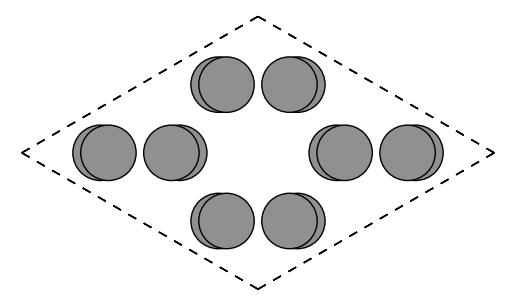

In [121]:
from ase.visualize.plot import plot_atoms
fig, ax = plt.subplots()
rep = 2
g = graphene.copy()
p1 = g.positions[0]
p2 = g.positions[1]
d = g.get_distance(0, 1, mic = True)
distortion = 0.1
g.set_positions([p1 + np.array([distortion*d, 0, 0]), p2 - np.array([distortion*d, 0, 0])])
E2g_graphene_last = g

for g in [E2g_graphene[0], E2g_graphene_last]:
    plot_atoms(g.repeat((rep, rep, 1)), ax = ax, radii = np.ones(rep**2*2)*0.5)
ax.axis("off")
# fig.savefig('images_GM/graphene_E2g.png')

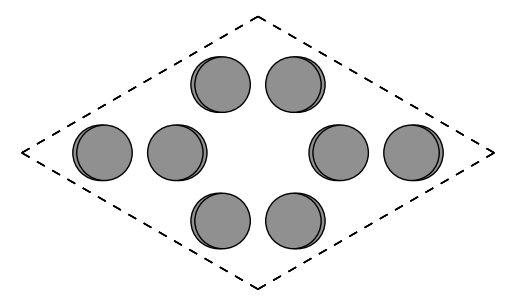

In [71]:
from ase.visualize.plot import plot_atoms
fig, ax = plt.subplots()
rep = 2
for g in [E2g_graphene[0], E2g_graphene[-1]]:
    plot_atoms(g.repeat((rep, rep, 1)), ax = ax, radii = np.ones(rep**2*2)*0.5)
ax.axis("off")
fig.savefig('images_GM/graphene_E2g.png')

In [18]:
E2g_dataset = QMDataset(frames = E2g_graphene, kmesh = kmesh, 
                                   fock_kspace = [kfock]*len(E2g_graphene), # Dummy target
                                   overlap_kspace = [kover]*len(E2g_graphene), # Dummy target
                                   device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

In [19]:
E2g_rhoij = pair_features(E2g_dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = True,
                      kmesh = E2g_dataset.kmesh, device="cpu", lcut = LCUT, return_rho0ij = False, counter = E2g_dataset._translation_counter, 
                      T_dict = E2g_dataset._translation_dict)

if both_centers and not return_rho0ij:
    NU = 3
else:
    NU = 2
E2g_rhonui = single_center_features(E2g_dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = 'cpu',
                                feature_names = E2g_rhoij.property_names)

E2g_hfeat = twocenter_features_periodic_NH(single_center = E2g_rhonui, pair = E2g_rhoij, all_pairs = True)

{'cutoff': 6, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.3, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/home/pegolo/Software/my_mlelec/src/mlelec/features/acdc.py:148: UserWarning: Using kmesh [[8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1], [8, 8, 1]] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


In [20]:
dummy_target_blocks, dummy_target_coupled_blocks = get_targets(E2g_dataset, cutoff = cutoff)

In [21]:
E2g_model = LinearModelPeriodic(twocfeat = E2g_hfeat, 
                                target_blocks = dummy_target_coupled_blocks,
                                frames = E2g_dataset.structures, orbitals = E2g_dataset.basis, 
                                device = device)

E2g_model = E2g_model.double()

In [22]:
E2g_predictions = predict(E2g_model, ridges_bias, dummy_target_coupled_blocks)
E2g_predictions_o = predict(E2g_model, ridges_bias_o, dummy_target_coupled_blocks)

In [23]:
from mlelec.utils.pbc_utils import blocks_to_matrix
E2g_focks = blocks_to_matrix(E2g_predictions, E2g_dataset)
E2g_overlaps = blocks_to_matrix(E2g_predictions_o, E2g_dataset)

### Plot bands

In [30]:
100*1.42/2

71.0

/tmp/ipykernel_283848/4152958245.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


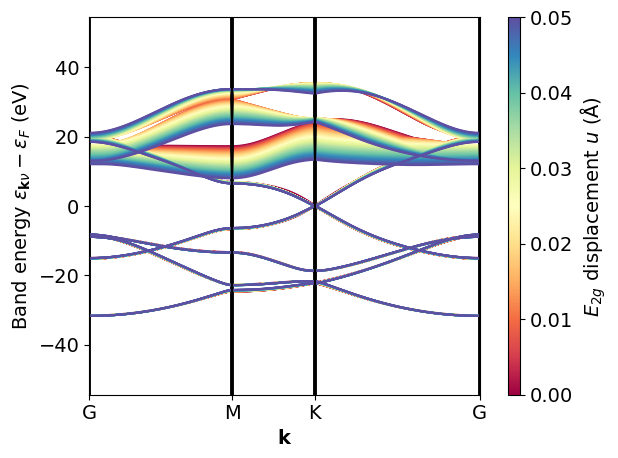

In [113]:
fig, axes = plt.subplots(ncols = 2, gridspec_kw = {'width_ratios': [1,0.03]})

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, -0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ax = axes[0]
cmap = matplotlib.cm.get_cmap('Spectral')
bands = []
ifr = 0
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(dataset.overlap_realspace[0].values()))
ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = cmap(0))
# bands.append(b)

nmax = 50
for ifr in range(0, nmax):
    frame = E2g_dataset.structures[ifr]
    pyscf_cell = E2g_dataset.cells[ifr]
    kmesh = E2g_dataset.kmesh[ifr]
    kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
    realfock = np.asarray(list(E2g_focks[ifr].values()))
    realover = np.asarray(list(E2g_overlaps[ifr].values()))
    # realover = np.asarray(list(E2g_overlaps[ifr].values()))
    ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
                              kpath = kpath, ax = ax, color = cmap((ifr+1)/nmax))
    bands.append(b)
bands = np.array(bands)
ax.set_ylabel(r'Band energy $\epsilon_{\mathbf{k}\nu} - \varepsilon_F$ (eV)')

ax = axes[1]
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), ax)
cbar.set_ticks(np.arange(0, nmax+1, 10)/50)
cbar.set_ticklabels([f'{v:.2f}' for v in np.linspace(0, 0.05, 50, endpoint = True)[::10]] + ['0.05'])
cbar.set_label(r'$E_{2g}$ displacement $u$ ($\mathrm{\AA}$)')

fig.tight_layout()
fig.savefig('images_GM/graphene_E2g_bands.png')

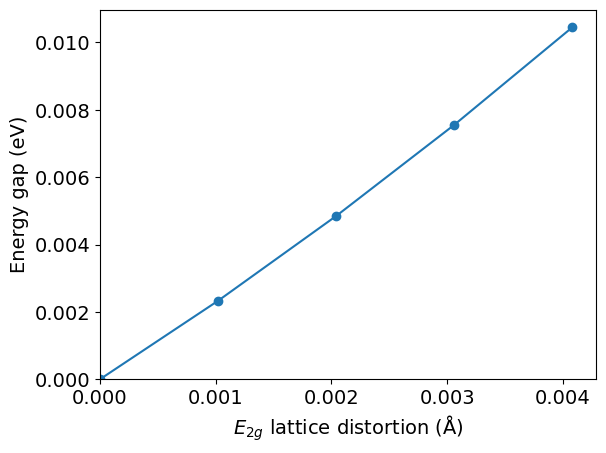

In [114]:
fig, ax = plt.subplots()

x = np.linspace(0, 0.05, 50, endpoint = True)
y = np.min(bands[:, 6, :] - bands[:, 5, :], axis = 1)

ax.plot(x[x<0.0051], y[x<0.0051], '-o')
ax.set_xlabel('$E_{2g}$ lattice distortion ($\mathrm{\AA}$)')
ax.set_ylabel('Energy gap (eV)')

ax.set_xlim(0,)
ax.set_ylim(0,)
fig.savefig('images_GM/graphene_E2g_gap.png')

# Test

In [86]:
E2g_graphene_true = read('examples/data/periodic/E2g_graphene/E2g_graphene.xyz', ':')
kmesh = [8,8,1]
kfock = [np.load(f'examples/data/periodic/E2g_graphene/E2g_fock_{ifr}.npy') for ifr in range(len(E2g_graphene_true))]
kover = [np.load(f'examples/data/periodic/E2g_graphene/E2g_over_{ifr}.npy') for ifr in range(len(E2g_graphene_true))]
for ifr in range(len(E2g_graphene_true)):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, graphene, orbitals[ORBS]) #### TODO <<
    for ik, k in enumerate(kover[ifr]):
        kover[ifr][ik] = fix_orbital_order(k, graphene, orbitals[ORBS]) #### TODO <<
    
E2g_dataset_true = QMDataset(frames = E2g_graphene_true, kmesh = kmesh, 
                                   fock_kspace = kfock,                                   
                                   overlap_kspace = kover,
                                   device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

/tmp/ipykernel_283848/4192388848.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


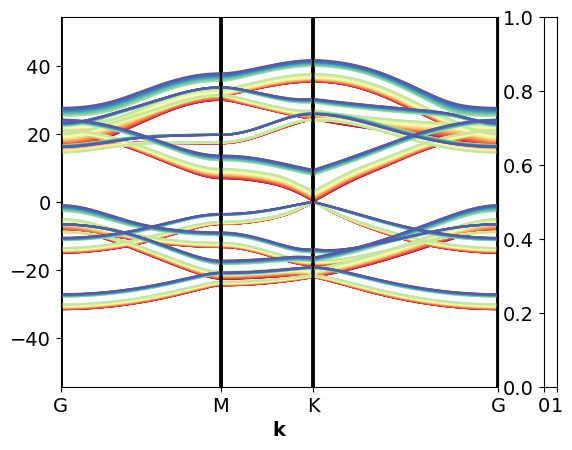

In [110]:
fig, axes = plt.subplots(ncols = 2, gridspec_kw = {'width_ratios': [1,0.03]})

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, -0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ax = axes[0]
cmap = matplotlib.cm.get_cmap('Spectral')
bands = []
for ifr in range(len(E2g_dataset_true.structures)):
    frame = E2g_dataset_true.structures[ifr]
    pyscf_cell = E2g_dataset_true.cells[ifr]
    kmesh = E2g_dataset_true.kmesh[ifr]
    kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
    realfock = np.asarray(list(E2g_dataset_true.fock_realspace[ifr].values()))
    realover = np.asarray(list(E2g_dataset_true.overlap_realspace[ifr].values()))
    ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, 
                              color = cmap(ifr/len(E2g_dataset_true.structures)))
    bands.append(b)
bands = np.array(bands)

# nmax = 50
# for ifr in range(0, nmax):
#     frame = E2g_dataset.structures[ifr]
#     pyscf_cell = E2g_dataset.cells[ifr]
#     kmesh = E2g_dataset.kmesh[ifr]
#     kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
#     realfock = np.asarray(list(E2g_focks[ifr].values()))
#     realover = np.asarray(list(E2g_overlaps[ifr].values()))
#     # realover = np.asarray(list(E2g_overlaps[ifr].values()))
#     ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax = ax, color = cmap((ifr+1)/nmax))
#     bands.append(b)
# bands = np.array(bands)
# ax.set_ylabel(r'Band energy $\epsilon_{\mathbf{k}\nu} - \varepsilon_F$ (eV)')

# ax = axes[1]
# cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), ax)
# cbar.set_ticks(np.arange(0, nmax+1, 10)/50)
# cbar.set_ticklabels([f'{v:.2f}' for v in np.linspace(0, 0.05, 50, endpoint = True)[::10]] + ['0.05'])
# cbar.set_label(r'$E_{2g}$ displacement $u$ ($\mathrm{\AA}$)')

# fig.tight_layout()
# fig.savefig('images_GM/graphene_E2g_bands.png')

(0.0, 0.4548663273283825)

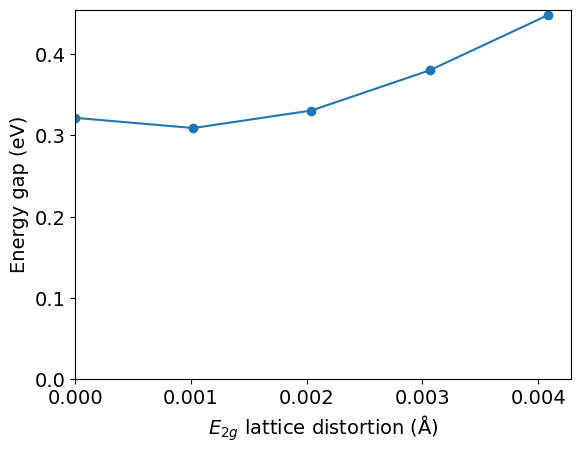

In [111]:
fig, ax = plt.subplots()

x = np.linspace(0, 0.05, 50, endpoint = True)
y = np.min(bands[:, 6, :] - bands[:, 5, :], axis = 1)

ax.plot(x[x<0.0051], y[x<0.0051], '-o')
ax.set_xlabel('$E_{2g}$ lattice distortion ($\mathrm{\AA}$)')
ax.set_ylabel('Energy gap (eV)')

ax.set_xlim(0,)
ax.set_ylim(0,)

In [96]:
bands.shape

(50, 10, 500)

In [4]:
orbitals = {
    'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
           
    'gthtzvpmolopt': {6: [[1, 0, 0], [2, 0, 0], [3, 0, 0], 
                            [2, 1, 1], [2, 1, -1], [2, 1, 0], 
                            [3, 1, 1], [3, 1, -1], [3, 1, 0], 
                            [4, 1, 1], [4, 1, -1], [4, 1, 0],
                            [3, 2, -2], [3, 2, -1], [3, 2, 0], [3, 2, 1], [3, 2, 2]]
                            },
    'gthszvmolopt': {6: [[2, 0, 0], 
                         [2, 1, 1], [2, 1, -1], [2, 1, 0]]
                            }
           }

In [14]:
root = 'examples/data/periodic/c2'
ORBS = 'gthszvmolopt'
graphene = read(f'{root}/C2_174.extxyz', '0')
graphene.pbc = True

kmesh = [15,15,1]
kfock = np.load('/home/pegolo/Software/my_mlelec/examples/data/periodic/c2/cp2k/fock_0.npy')
kover = np.load('/home/pegolo/Software/my_mlelec/examples/data/periodic/c2/cp2k/overlap_0.npy')

# nao = kfock_.shape[1]
# kfock = np.zeros((*kmesh, kfock_.shape[1], kfock_.shape[2]), dtype = np.complex128)
# kover = np.zeros((*kmesh, kfock_.shape[1], kfock_.shape[2]), dtype = np.complex128)
# for i in range(kmesh[0]):
#     for j in range(kmesh[1]):
#         for k in range(kmesh[2]):
#             kfock[i, j, k, :, :] = kfock_.reshape(*kmesh, kfock_.shape[1], kfock_.shape[2])[i-7,j-7,k, :, :]
#             kover[i, j, k, :, :] = kover_.reshape(*kmesh, kfock_.shape[1], kfock_.shape[2])[i-7,j-7,k, :, :]
# kfock = kfock.reshape(np.prod(kmesh), nao, nao)
# kover = kover.reshape(np.prod(kmesh), nao, nao)

for ik, k in enumerate(kfock):
    kfock[ik] = fix_orbital_order(k, graphene, orbitals[ORBS]) #### TODO <<
for ik, k in enumerate(kover):
    kover[ik] = fix_orbital_order(k, graphene, orbitals[ORBS]) #### TODO <<

dataset = QMDataset(frames = [graphene], kmesh = kmesh, fock_kspace = [kfock], overlap_kspace = [kover], 
                               device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.



/tmp/ipykernel_3564204/3176623655.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


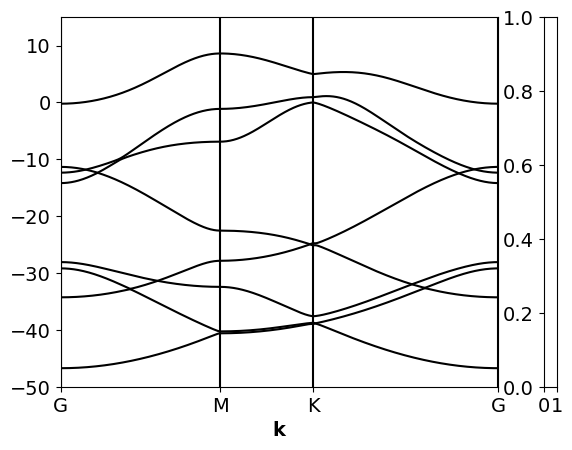

In [16]:
fig, axes = plt.subplots(ncols = 2, gridspec_kw = {'width_ratios': [1,0.03]})

special_points = {'G': [0.0, 0.0, 0.0], 'K': [1/3, 1/3, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ax = axes[0]
cmap = matplotlib.cm.get_cmap('Spectral')
bands = []
for ifr in [0]:
    frame = dataset.structures[ifr]
    pyscf_cell = dataset.cells[ifr]
    kmesh = dataset.kmesh[ifr]
    kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
    realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
    realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
    ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh, special_symm = 'hexagonal', kpath = kpath, ax = ax, 
                              color = 'k')
    bands.append(b)
ax.set_ylim(-50, 15)
bands = np.array(bands)